## TODO: 
- Capa de MySQL code validation? -> Y que pasa despues si hay un error? creo que no va.
- Eliminar las cardinalidades que no estén pegadas a ninguna tabla o que estén X distancia lejos. Hay que graficar para establecer un threshold
- Limpiar el nms.. funciona mal aún

In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import sys
sys.path.append("../")

from src.training_utils.training import load_model
from src.line_detection.hough import *
from ast import literal_eval
from src.ocr_utils.ocr import *
from src.slides_utils.slides_utils import slice_img_from_prediction

In [172]:
import os
import cv2
import torch
import spacy
import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
from torchvision import transforms as T
import torchvision
from paddleocr import PaddleOCR

2023-02-13 00:23:18.708245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 00:23:21.787691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-13 00:23:21.788072: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [4]:
PATH_MODELS = "/home/nacho/TFI-Cazcarra/data/models"
PATH_YOLO = "/home/nacho/TFI-Cazcarra/yolov3/runs/train"

## Realizo predicciones

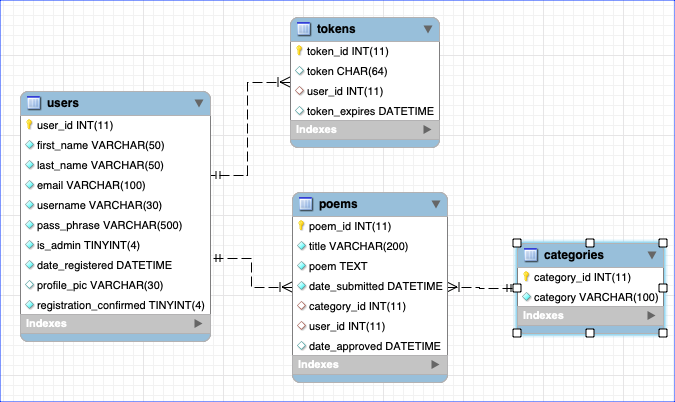

In [97]:
img_path = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-5.png'
img = Image.open(img_path).convert("RGB")
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
img

In [6]:
def draw_bbox(img, xmin, ymin, xmax, ymax, score, label): 
    txt = get_class_name(label, le_dict) + ' ' + str(score)
    img = cv2.putText(img, txt, (int(xmin), int(ymin)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255), 1)

    return cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), 
                         (255,0,0), 1)

### 1. Extraigo las tablas

In [7]:
retinanet_tablas = load_model(os.path.join(PATH_MODELS, "model_best_tablas_retinanet.pt"))
faster_rcnn_tablas = load_model(os.path.join(PATH_MODELS, "model_best_tablas_fasterrcnn.pt"))

In [8]:
yolo_tablas = torch.hub.load('ultralytics/yolov5', 'custom', \
                             os.path.join(PATH_YOLO, "exp5", "weights", "best.pt"))

Using cache found in /home/nacho/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-8 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 261 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
Adding AutoShape... 


In [28]:
def filter_predictions(predictions, score_threshold=0.5, nms_threshold=0.1):
    boxes = predictions['boxes'][predictions['scores'] >= score_threshold]
    scores = predictions['scores'][predictions['scores'] >= score_threshold]
    valid_idx = torchvision.ops.nms(boxes, scores, nms_threshold)
    return boxes[valid_idx], scores[valid_idx]

In [36]:
tablas_1 = retinanet_tablas([img_tensor])[1][0]
boxes_1, scores_1 = fusion_predictions_pytorch(tablas_1)

In [38]:
tablas_2 = faster_rcnn_tablas([img_tensor])[1][0]
boxes_2, scores_2 = fusion_predictions_pytorch(tablas_2)

In [39]:
tablas_3 = yolo_tablas(img)
tablas_3 = {"boxes": tablas_3.xyxyn[0][:, :4], "scores": tablas_3.xyxyn[0][:, 4]}
boxes_3, scores_3 = fusion_predictions_pytorch(tablas_3)

### 2. Extraigo las cardinalidades

In [149]:
def unify_images(img, boxes_per_tile):
    img = np.array(img)
    first_tile = next(iter(boxes_per_tile.keys()))
    all_boxes = np.array([[]])
    all_scores = np.array([])
    
    for tile, prediction in boxes_per_tile.items():
        coords_to_add = torch.Tensor(list(map(lambda i,j: i-j, literal_eval(tile), literal_eval(first_tile))))
        boxes = torch.add(prediction['boxes'], coords_to_add, alpha=1).detach().numpy()
        all_boxes = np.append(all_boxes, boxes)
        all_scores = np.append(all_scores, prediction['scores'])
    return {"boxes": torch.from_numpy(all_boxes.reshape((-1,4))), "scores": torch.from_numpy(all_scores)}


def predict_tiles(img, model, is_yolo):
    tiles = slice_img_from_prediction(img, tile_size=None, tile_overlap=0.0, number_tiles=6)
    
    preds_image = {}
    with torch.no_grad():
        for tile in tiles:
            tile_img = img.crop(tile).convert("RGB")
            tensor_tile = transform(tile_img)
            if not is_yolo:
                predictions = model([tensor_tile])[1][0]
            else:
                predictions = model(tile_img)
                predictions = {"boxes": predictions.xyxyn[0][:, :4], "scores": predictions.xyxyn[0][:, 4]}
            preds_image[str(tile)] = predictions
    unified_results = unify_images(img=img, boxes_per_tile=preds_image)
    boxes, scores = fusion_predictions_pytorch(unified_results)
    return boxes, scores

In [65]:
retinanet_cardinalidades = load_model(os.path.join(PATH_MODELS, "model_best_cardinalidades_retinanet.pt"))
faster_rcnn_cardinalidades = load_model(os.path.join(PATH_MODELS, "model_best_cardinalidades_fasterrcnn.pt"))

yolo_cardinalidades = torch.hub.load('ultralytics/yolov5', 'custom', \
                             os.path.join(PATH_YOLO, "exp3", "weights", "best.pt"))

Using cache found in /home/nacho/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-8 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 261 layers, 61513585 parameters, 0 gradients, 154.6 GFLOPs
Adding AutoShape... 


In [151]:
boxes_c1, scores_c1 = predict_tiles(img, retinanet_cardinalidades, False)
boxes_c2, scores_c2 = predict_tiles(img, faster_rcnn_cardinalidades, False)
boxes_c3, scores_c3 = predict_tiles(img, yolo_cardinalidades, True)

In [152]:
boxes_c3

tensor([[1.35433e+02, 2.47774e-01, 1.35497e+02, 3.20171e-01],
        [8.62141e-01, 2.47483e-01, 9.27957e-01, 3.21119e-01],
        [1.35235e+02, 1.21155e+02, 1.35290e+02, 1.21219e+02],
        [6.63854e-01, 8.77734e-01, 7.19635e-01, 9.43707e-01],
        [3.60272e+02, 1.21552e+02, 3.60330e+02, 1.21618e+02],
        [6.63101e-01, 1.21154e+02, 7.17775e-01, 1.21220e+02],
        [1.35236e+02, 8.78654e-01, 1.35292e+02, 9.43210e-01],
        [3.60444e+02, 1.21558e+02, 3.60490e+02, 1.21616e+02],
        [8.70287e-01, 1.21551e+02, 9.32346e-01, 1.21622e+02],
        [1.35439e+02, 1.21548e+02, 1.35507e+02, 1.21622e+02],
        [6.61990e-01, 1.21449e+02, 7.20045e-01, 1.21516e+02],
        [1.35235e+02, 1.21451e+02, 1.35292e+02, 1.21515e+02],
        [6.64459e-01, 5.84363e-01, 7.16913e-01, 6.49347e-01],
        [1.35237e+02, 5.86359e-01, 1.35289e+02, 6.49575e-01]], dtype=torch.float64)

## Encuentro las líneas y junto con las cardinalidades

In [155]:
OFFSET_TABLAS = 5

In [163]:
def find_lines(img_path, tablas, cardinalidades):
    img_basename = os.path.basename(img_path)

#     tablas, cardinalidades = get_tablas(img_basename)
    #Agrandamos un toque las cajas
    offset = np.array([-OFFSET_TABLAS, -OFFSET_TABLAS, OFFSET_TABLAS, OFFSET_TABLAS]).reshape(1,4)
    tablas = np.sum([tablas, offset])

    #No le paso las cardinalidades.
    img, all_lines = apply_hough(img_path, tablas, [])

    all_points = lines_to_points(all_lines)
    lines = hough_detecting(all_points)

    return unify_cardinalidades(img, lines, cardinalidades)

In [164]:
def line_to_points(x, y, max_dst_per_points=2):
    dst_line = math.dist(x,y)
    parts = dst_line // max_dst_per_points
    return np.linspace(x, y, int(parts)+1).tolist()


def dist_func(comb):
    return math.dist(comb[0], comb[1])


def get_centroid(cardinalidad):
    center_x  = cardinalidad[0] + (cardinalidad[2] - cardinalidad[0])/2
    center_y  = cardinalidad[1] + (cardinalidad[3] - cardinalidad[1])/2
    return (center_x, center_y)


def nearest_tabla_from_cardinalidad(cardinalidad, tablas):
    # Dadas las coords de una cardinalidad, devolver a qué tabla está más cerca.
    # TODO: Puedo mezclarlo con el de OCR y reemplazar las coordenadas por el nombre de la
    # tabla... asi se entiende mejor. Esto quizás no hace falta pero no estaría mal.
    cardinalidad = literal_eval(cardinalidad)
    cardinalidad_centroid = get_centroid(cardinalidad)
    dict_dist_tablas = {}
    for t in tablas:
        tabla_points = []
        # De x1y1 a x2y1
        tabla_points += line_to_points((t[0], t[1]), (t[2], t[1]))
        # De x1y1 a x1y2
        tabla_points += line_to_points((t[0], t[1]), (t[0], t[3]))
        # De x1y2 a x2y2
        tabla_points += line_to_points((t[0], t[3]), (t[2], t[3]))
        # De x2y1 a x2y2
        tabla_points += line_to_points((t[2], t[1]), (t[2], t[3]))
        dist_cardinalidad = [(cardinalidad_centroid, point) for point in tabla_points]
        min_combination = min(dist_cardinalidad, key=dist_func)
        dict_dist_tablas[",".join([str(c) for c in t])] = dist_func(min_combination)
    nearest_tabla = min(dict_dist_tablas, key=dict_dist_tablas.get)
    return [int(c) for c in nearest_tabla.split(",")]

In [167]:
boxes_1.detach().numpy().astype(int).tolist()

[[18, 89, 209, 344],
 [286, 17, 441, 147],
 [292, 189, 452, 381],
 [515, 241, 664, 331]]

In [169]:
boxes_c1.detach().numpy().astype(int)

array([[273, 276, 292, 294],
       [271,  72, 289,  89],
       [210, 164, 227, 181],
       [447, 277, 464, 295],
       [210, 248, 225, 265],
       [499, 281, 513, 296]])

In [170]:
pairs = []

img_basename = os.path.basename(img_path)
tablas, _ = get_tablas(img_basename)

for line_name, line in find_lines(img_path, tablas=boxes_1.detach().numpy().astype(int), 
                                  cardinalidades=boxes_c1.detach().numpy().astype(int)).items():
    cardinalidades = line.split("|")
    tabla_a = nearest_tabla_from_cardinalidad(cardinalidades[0], tablas)
    tabla_b = nearest_tabla_from_cardinalidad(cardinalidades[1], tablas)
    pairs.append((tabla_a, tabla_b))

In [171]:
pairs

[([291, 191, 449, 383], [18, 89, 211, 344]),
 ([289, 16, 440, 150], [18, 89, 211, 344]),
 ([291, 191, 449, 383], [516, 241, 664, 334])]

## OCR

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

In [173]:
# TODO: Choose algo and language.
DET_ALGO = "db" # or "east"
REC_ALGO = "svtr" # or "crnn"
LANG = "en"

if LANG == "es":
    nlp_spanish = spacy.load("es_core_news_sm")
else:
    nlp_english = spacy.load("en_core_web_sm")

ocr = PaddleOCR(use_angle_cls=False, lang=LANG, show_log=False, 
                det_algorithm_dir=f"/home/nacho/TFI-Cazcarra/ocr/{DET_ALGO}/", 
                rec_algorithm_dir=f"/home/nacho/TFI-Cazcarra/ocr/{REC_ALGO}/", det_db_score_mode="slow") 

In [174]:
coords = []
results = []

img_arr = np.array(img)

for t in tablas:
    tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
    tabla_cropped = reescale(tabla_cropped)
    if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
        tabla_cropped = tabla_cropped[:,:,:3]
    result = ocr.ocr(tabla_cropped, cls=False)
    
    coords.append(t.tolist())
    results.append(result[0])

In [175]:
all_tables = {}
tables_names = {}

for c, r in zip(coords, results):
    boxes = [line[0] for line in r]
    txts = [line[1][0].strip() for line in r]
    scores = [line[1][1] for line in r]
    table, dict_attributes = clean_texts(txts)
    all_tables[table] = dict_attributes
    tables_names[table] = c

In [176]:
def pairs_to_names(pairs, tables_names):
    new_pairs = []
    tables_names = {str(v):k for k,v in tables_names.items()}
    
    for pair in pairs:
        tabla_a, tabla_b = pair
        tabla_a, tabla_b = tables_names[str(tabla_a)], tables_names[str(tabla_b)]
        new_pairs.append((tabla_a, tabla_b))
    return new_pairs

In [177]:
pairs = pairs_to_names(pairs, tables_names)

In [178]:
def extract_candidate_keys(table_attributes):
    return [attr for attr in table_attributes if "_id" in attr]

In [179]:
def get_primary_keys(candidates, fks):
    return list(set(candidates) - set(fks))

def get_foreign_keys(table, candidates, pairs, lemmatizer=nlp_english):
    def is_foreign_key(table_pair, candidates, table, lemmatizer):
        pair = table_pair + "_id"
        
        table_pair_lemmatized = lemmatizer(table_pair)[0].lemma_
        pair_lemmatized = table_pair_lemmatized + "_id"
        
        table_match = (table_pair == table or table_pair_lemmatized == table)
        
        pair_match = (pair in candidates and not table_match)
        pair_lemmatized_match = (pair_lemmatized in candidates and not table_match)
                
        if pair_match:
            return True, pair
        elif pair_lemmatized_match:
            return True, pair_lemmatized
        else:
            return False, ""
    """
    Ejemplo:
    table -> poems
    candidates -> ['poems_id', 'users_id', 'categories_id']
    pairs -> [('tokens', 'users'), ('poems', 'users'), ('poems', 'categories')]
    """
    fks = {}
    for pair in pairs:
        if table not in pair:
            continue
        is_fk_pair0, p0 = is_foreign_key(table_pair=pair[0], candidates=candidates, \
                                         table=table, lemmatizer=lemmatizer)
        is_fk_pair1, p1 = is_foreign_key(table_pair=pair[1], candidates=candidates, \
                                         table=table, lemmatizer=lemmatizer)
        if is_fk_pair0:
            fks[p0] = pair[0]
        elif is_fk_pair1:
            fks[p1] = pair[1]
    return fks

In [180]:
## TODO: En base a esto construir las FK y las PK. Una vez hecho eso, también definir las many to many.
for k in all_tables.keys():  
    candidates = extract_candidate_keys(all_tables[k].keys())
    fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
    pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
    print(f"Table: {k}")
    print(f"Candidates: {candidates}")
    print(f"FKS: {fks}")
    print(f"PKS: {pks}")
    print("####################")

Table: users
Candidates: ['user_id']
FKS: {}
PKS: {'user_id': 'users'}
####################
Table: poems
Candidates: ['poem_id', 'category_id', 'user_id']
FKS: {'user_id': 'users', 'category_id': 'categories'}
PKS: {'poem_id': 'poems'}
####################
Table: tokens
Candidates: ['token_id', 'user_id']
FKS: {'user_id': 'users'}
PKS: {'token_id': 'tokens'}
####################
Table: categories
Candidates: ['category_id']
FKS: {}
PKS: {'category_id': 'categories'}
####################


In [182]:
def generate_pks_code(pks):
    keys = pks.keys()
    keys = ", ".join(keys)
    return f"PRIMARY KEY ({keys})"

def generate_fks_code(table, fks):
    code = ""
    for fk, table_reference in fks.items():
        code += f"ALTER TABLE {table} ADD FOREIGN KEY ({fk}) REFERENCES {table_reference}({fk}); \n"
    return code

In [187]:
def create_code(table, dict_attributes, primary_keys, foreign_keys):
    '''
    Crea una tabla de MySQL
    '''
    attributes_code = "  "
    i = 0
    for k, v in dict_attributes.items():
        attributes_code += k + " " + v           
        attributes_code += ",\n   "
        i += 1
    pks_code = generate_pks_code(primary_keys)
    fks_code = generate_fks_code(table, foreign_keys)
    if pks_code:
        attributes_code += pks_code
    code = f" CREATE TABLE {table} ( \n {attributes_code} \n ); \n"
    return code, fks_code

In [192]:
all_code = ""
all_fks_code = ""
for k, dict_attributes in all_tables.items():
    candidates = extract_candidate_keys(all_tables[k].keys())
    fks = get_foreign_keys(table=k, candidates=candidates, pairs=pairs)
    pks = {pk: k for pk in get_primary_keys(candidates, fks.keys())}
    code, fk_code = create_code(k, dict_attributes, pks, fks)
    all_code += code
    all_fks_code += fk_code
    
print(all_code + "\n" + all_fks_code)

 CREATE TABLE users ( 
   user_id INT(11),
   first_name VARCHAR(50),
   last_name VARCHAR(50),
   email VARCHAR(100),
   username VARCHAR(30),
   pass_phrase VARCHAR(500),
   is_admin TINYINT(4),
   date_registered DATETIME,
   profile_pic VARCHAR(30),
   registration_confirmed TINYINT(4),
   PRIMARY KEY (user_id) 
 ); 
 CREATE TABLE poems ( 
   poem_id INT(11),
   title VARCHAR(200),
   poem TEXT,
   date_submitted DATETIME,
   category_id INT(11),
   user_id INT(11),
   date_approved DATETIME,
   PRIMARY KEY (poem_id) 
 ); 
 CREATE TABLE tokens ( 
   token_id INT(11),
   token CHAR(64),
   user_id INT(11),
   token_expires DATETIME,
   PRIMARY KEY (token_id) 
 ); 
 CREATE TABLE categories ( 
   category_id INT(11),
   category VARCHAR(100),
   PRIMARY KEY (category_id) 
 ); 

ALTER TABLE poems ADD FOREIGN KEY (user_id) REFERENCES users(user_id); 
ALTER TABLE poems ADD FOREIGN KEY (category_id) REFERENCES categories(category_id); 
ALTER TABLE tokens ADD FOREIGN KEY (user_id) REFERENC

## Una vez que está todo hecho, unificar acá y detectar puntos de mejora.